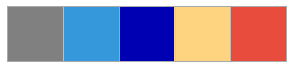

In [264]:
import random
from six.moves import cPickle as pickle
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Circle
rc('text', usetex=True)
rc('text.latex', preamble='\\usepackage{color}')
from PIL import Image
import numpy as np
from scipy.misc import comb
from math import log, exp, sqrt
from collections import Counter
import seaborn as sns
sns.set_context("paper")
# sns.set_context('talk')
import string
import json
import pickle
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
COLORS = ["#808080", "#3498db", "#0000b3", "#ffd480", "#e74c3c"]
sns.palplot(sns.color_palette(COLORS))

In [10]:
def distrib(m, v, tau=0.7):
    x = [comb(m, d, exact=False) * (v-1)**d / v**m * exp(-d/tau) for d in range(m+1)]
    x = np.array(x)
    x/= np.sum(x)
    return x

In [ ]:
# m = 16
# V1 = 180
# V2 = 9800
m = 16
V1 = 30
taus1 = [.2, .3, .4]
V2 = 180
taus2= [.15,.17, .2]
V3 = 9800
taus3= [0.09, 0.10, 0.12]
V4 = 300
taus4= [0.13, 0.15, 0.17]
yt = .28
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'black'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
fig, axs = plt.subplots(2, 2, figsize=(16, 16), sharey=True)
markers = ['*', '^', 'o', 's']
for i, tau in enumerate(taus1):
    axs[0,0].plot(range(m+1) , distrib(m, V1, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[0,0].legend()
axs[0,0].set_xticks(4 * np.arange(m//4 +1))
axs[0,0].text(.4*m, yt, '$V_{pool}=%d$'% V1)
axs[1,0].set_xlabel('d')

for i, tau in enumerate(taus2):
    axs[0,1].plot(range(m+1),
                  distrib(m, V2, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[0,1].legend()
axs[0,1].set_xticks(4 * np.arange(m//4 +1))
axs[0,1].text(.4*m, yt, '$V_{pool}=%d$'% V2)
axs[0,1].set_xlabel('d')

for i, tau in enumerate(taus3):
    axs[1,0].plot(range(m+1),
                  distrib(m, V3, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[1,0].legend()
axs[1,0].set_xticks(4 * np.arange(m//4 +1))
axs[1,0].text(.4*m, yt, '$V_{pool}=%d$'% V3)
axs[1,0].set_xlabel('d')


m = 50
for i, tau in enumerate(taus4):
    axs[1,1].plot(range(m+1),
                  distrib(m, V4, tau),
                  marker=markers[i],
                  label="$\\tau=%.2f$" % tau)
axs[1,1].legend()
axs[1,1].set_xticks(4 * np.arange(m//4 +1))
axs[1,1].text(.4*m, yt, '$V_{pool}=%d$'% V4)
axs[1,1].set_xlabel('d')
plt.tight_layout()

plt.savefig('../figures/hamming_q.png', dpi=400, bbox_inches='tight')

## word neighbors

In [11]:
# Constants
itow = json.load(open('../data/coco/cocotalk.json', 'r'))['ix_to_word']
WORDS = {int(k): v for k, v in itow.items()}
if 0 not in WORDS:
    WORDS[0] = 'EOS'
MATCH = {v: k for k,v in WORDS.items()}
del itow
FF = pickle.load(open('../data/coco/idf_coco_01.pkl', 'rb'))
F = pickle.load(open('cooc_freq.pkl', 'rb'))[0]

# utils:
def normalize(A):
    l1 = A.sum(axis=1)
    A /= l1.reshape(len(A), 1)
    return A

def invocab(ngram):
    for w in ngram:
        if w not in MATCH:
            return False
    return True

def space(xy, points, delta=1):
    x , y = xy
    xs = np.array([p[0] for p in points])
    ys = np.array([p[1] for p in points])
    while np.any(np.absolute(xs -x) < delta):
        x += delta
    while np.any(np.absolute(ys -y) < delta):
        y += delta
    return [x, y]

def exps(sim, tau=0.2, freq=False):
    if freq:
        return normalize(np.exp((sim-1 - tau * FF)/tau))
    else:
        return normalize(np.exp((sim-1)/tau))
    
sim_wiki = pickle.load(open('../data/Glove/glove_wiki_d300_w15_similarities.pkl',
                             'rb'), encoding='iso-8859-1')
sim_coco = pickle.load(open('../data/Glove/glove_coco_d300_w15_similarities.pkl','rb'))


In [131]:
def plot_word_neighbors(axs, selected, sim1, sim2, labels,
                        NN=10, verbose=0, legend=0):
    sns.set()
    ax2, ax = axs
    h = .05
    colors = sns.color_palette("Paired", NN)
    k = MATCH[selected]
    nbrs1 = np.flip(sim1[k].argsort()[-NN:][::-1], axis=0)
    nbrs2 = np.flip(sim2[k].argsort()[-NN:][::-1], axis=0)
    nbrs = list(set(nbrs1).union(set(nbrs2)))
    nbrs.remove(k)
    nbrs = nbrs + [k]
#     print('neighbors:', nbrs)
    wnbrs = [WORDS[i] for i in nbrs]
    simnbrs1 = [sim1[k,i] for i in nbrs]
    simnbrs2 = [sim2[k,i] for i in nbrs]
    ys = 4 / 3 * h * np.arange(len(nbrs))
    ax2.get_shared_y_axes().join(ax, ax2)
    ax2.set_xlim(1e-6, 1)
    ax2.text(1e-4,-.165,"freq", fontsize=18)
    ax2.invert_xaxis()
    ax2.yaxis.tick_right()
    freqnbrs = [F[i] for i in nbrs]
    if verbose:
        print('freq', freqnbrs)
        print('sim', simnbrs)
    ax2.barh(ys, freqnbrs, height=h,
             align='edge', color=COLORS[3])
    
    ax2.set_xscale("log", nonposx='clip')
#     ax2.set_xlabel('freq')
    
    ax2.axis('off')
    ax.barh(ys+2*h/3, [0] * (len(nbrs)-1) + [1], height=h/3,
            align='edge', color=COLORS[0], alpha=.5,
           label="MLE")
    ax.barh(ys+h/3, simnbrs1, height=h/3,
            align='edge', color=COLORS[1], alpha=.7,
           label=labels[0])
    ax.barh(ys, simnbrs2, height=h/3,
            align='edge', color=COLORS[2], alpha=.7,
            label=labels[1])
    ax.set_yticks(ys + h/2)
    ax.tick_params('y', labelsize=14)
    ax.set_yticklabels(wnbrs)
    ax.set_ylim(min(ys), max(ys) + h)
    ax.set_xlim(1e-4, 1)
    ax.set_xscale("log", nonposx='clip')
    ax.set_xlabel('$r_\\tau(y|$%s$)$' % selected)
    
    if legend:
        ax.legend(fontsize=16, loc=4)
    plt.tight_layout()
#         plt.savefig('../figures/%s_nbrs_%s.png' % (prefix, WORDS[k]),
#                     dpi=300, bbox_inches='tight')


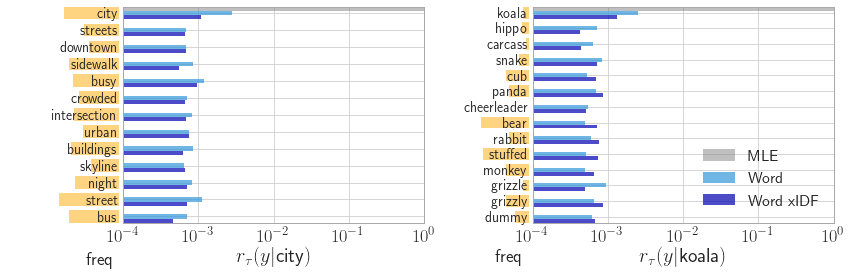

In [132]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
fig, axs = plt.subplots(1, 4, figsize=(12, 4),
                        gridspec_kw = {'width_ratios':[1, 3] * 2})
word = "city" #"street"
plot_word_neighbors(axs[:2], word,
                    exps(sim_coco, 0.15),
                    exps(sim_coco, 0.15, True),
                    ['Word', 'Word xIDF'])

word = "koala" #"street"
plot_word_neighbors(axs[2:4], word,
                    exps(sim_coco, 0.15),
                    exps(sim_coco, 0.15, True),
                    ['Word', 'Word xIDF'],
                   legend=1)

fig.tight_layout()
plt.subplots_adjust(wspace=0.02)

plt.savefig('../figures/words_nbrs_coco.png',
            dpi=300, bbox_inches='tight')


In [ ]:
frequent = F.argsort()[-80:][::-1]
for fr in frequent:
    print(WORDS[fr],)

In [ ]:
medium = F.argsort()[1300:1380]
for fr in medium:
    print(WORDS[fr],)

In [ ]:
rare = F.argsort()[60:90]
for fr in rare:
    print(WORDS[fr],)

In [7]:
def skim(arr, percentile):
    th = np.percentile(arr, percentile)
    arr[arr<th] = 0
    return arr

def plot_nbrs_picks(word, ax, legend=False):
    iw = MATCH[word]
    dirac = np.zeros(sim_coco.shape[0])
    dirac[MATCH[word]] = 1
    ax.plot(dirac, c='darkred', alpha=0.5, label="MLE - $\\delta$")

    default = skim(exps(sim_coco, 0.15, False)[iw], 99.5)
    ax.plot(default, c='darkgreen', label="Tok-Reward - $r_\\tau$", alpha=.5)

    xidf = skim(exps(sim_coco, 0.15, True)[iw], 99.5)
    ax.plot(xidf, c='mediumblue', label="Tok-Reward - $r_\\tau^{IDF}$", alpha=.5)
    if legend:
        ax.legend(fontsize=15, loc=2)
    wxidf = np.nonzero(xidf)[0]
    wdef = np.nonzero(default)[0]
    wperr = 4
    sel = np.concatenate((np.array([iw]),
                          np.random.choice(wdef, wperr),
                          np.random.choice(wxidf, wperr)))
    colors = ['darkred'] + wperr * ['darkgreen'] + wperr * ['mediumblue']
    for e, (s, c) in enumerate(zip(sel, colors)):
#         print('index:', s, 'default', default[s], 'xidf', xidf[s])
        if not e:
            scale=.5
            slide = 25
            pick = 1
        else:
            if e < wperr + 1:
                pick = default[s]
                slide = -400
                scale = 5
#                 print('e:', e, WORDS[s])
            else:
                pick = xidf[s]
                slide = 100
                scale = 3

        ax.annotate(WORDS[s].encode().decode(),
                    xy=(s, pick),
                    xytext=(s + slide, scale * pick),
                    color=c,
                    fontsize=18,
    #               arrowprops=dict(facecolor='black', shrink=0.05),
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3",
                                    facecolor=c,
                                    edgecolor=c))
    ax.set_yscale("log")
    ax.set_xticks([])
    ax.set_ylabel('$r_\\tau(y|$%s$)$' % word)
#     ax.set_xlabel('$\\mathcal V$')


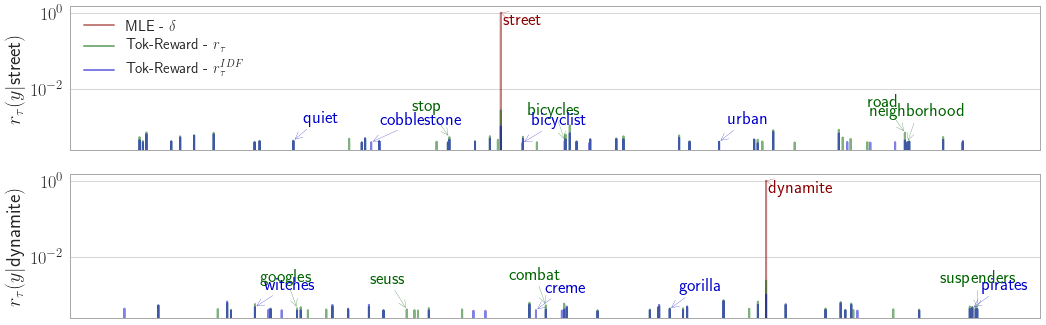

In [8]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})

f, axs = plt.subplots(2, 1, figsize=(15, 5))
np.random.seed(1244)
plot_nbrs_picks('street', axs[0], legend=True)

np.random.seed(17)
plot_nbrs_picks('dynamite', axs[1])

plt.tight_layout()
# plt.savefig('../figures/nbrs_picks.png',
#             dpi=300, bbox_inches='tight')

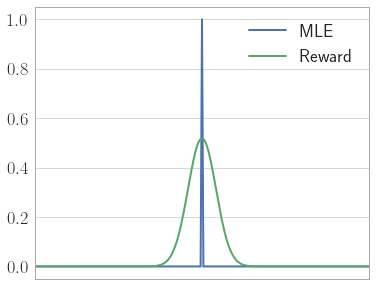

In [221]:
L = 800
x = np.arange(L)
y = np.zeros(L)
center = 300
a = 1e-5
y = 1/a * (1/np.pi * 1/(1+((x- center)/a)**2))
y /= np.sum(y)

if 0:
    centers = [center] + np.random.randint(low=1,
                                           high=L,
                                           size=10)
    sigmas = np.random.randint(low=1,
                               high=10,
                               size=10) / 10
    weights = [5] + np.random.randint(low=1,
                                      high=10,
                                      size=10)/2
    weights = weights / np.sum(weights)
    z = np.zeros(L)
    for w, c, s in zip(weights, centers, sigmas):
        z += w * np.exp(-(x-c)**2/2/s)
    # z += 1/30 * np.random.randn(50)
if 1:
    sigma = 10
    z = np.exp(-(x-center)**2/2/sigma**2)
z /= np.sum(z)
z = 13 * z
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})
plt.figure(figsize=(6,5))
plt.plot(x, y, label='MLE')
plt.plot(x, z, label='Reward')
plt.xlim([center-12*sigma, center+12*sigma])
plt.xticks([])
plt.legend()
# plt.xticks(centers, ['jungle', 'forest', 'clearing'], rotation=45)


### Sentences

In [133]:
import torch
GLOVE_PATH = '../../InferSent/dataset/GloVe/glove.840B.300d.txt'

In [136]:
import sys
sys.path.insert(0, '../../InferSent/encoder/')
model = torch.load('../../InferSent/encoder/infersent.allnli.pickle')

/home/maha/anaconda3/lib/python3.6/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [137]:
model.set_glove_path(GLOVE_PATH)
model.build_vocab_k_words(K=100000)
def embed_sent(sentences):
    embeddings = model.encode(sentences, bsize=128, tokenize=False, verbose=False)
    return embeddings

Vocab size : 100000


In [140]:
embed_sent(["a cat is playing"]).shape

../../InferSent/encoder/models.py:53: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid


(1, 4096)

In [207]:
A = json.load(open('../data/coco/captions_train2014.json', 'r'))['annotations']
caps = {}
for a in A:
    if a['image_id'] in caps:
        caps[a['image_id']].append(a['caption'].split())
    else:
        caps[a['image_id']] = [a['caption'].split()]

In [256]:
def alter(sentence, distance, vocab):
    sampled = sentence.copy()
    m = len(sampled)
    indices = list(range(m))
    print('indices:', indices)
    random.shuffle(indices)
    for k in indices[:distance]:
        sampled[k] = random.choice(vocab)
    return sampled, indices[:distance]
    

In [257]:
ids = list(caps)
select = ids[14]
gt = caps[select]
print(gt)

[['Two', 'women', 'preparing', 'food', 'in', 'a', 'kitchen,', 'one', 'at', 'the', 'sink', 'and', 'one', 'at', 'the', 'table'], ['A', 'set', 'table', 'with', 'silverware,', 'glasses', 'and', 'a', 'bottle', 'of', 'wine.'], ['A', 'woman', 'having', 'a', 'slice', 'of', 'bread', 'with', 'jelly.'], ['A', 'woman', 'sitting', 'at', 'a', 'table', 'with', 'win', 'and', 'bread.'], ['A', 'women', 'who', 'is', 'tearing', 'off', 'a', 'piece', 'of', 'bread.']]


In [258]:
vrefs = []
for g in gt:
    print(g)
    vrefs += g
print('vresf:', vrefs)
vrefs = list(set(vrefs))
print('Vrefs:', vrefs)

['Two', 'women', 'preparing', 'food', 'in', 'a', 'kitchen,', 'one', 'at', 'the', 'sink', 'and', 'one', 'at', 'the', 'table']
['A', 'set', 'table', 'with', 'silverware,', 'glasses', 'and', 'a', 'bottle', 'of', 'wine.']
['A', 'woman', 'having', 'a', 'slice', 'of', 'bread', 'with', 'jelly.']
['A', 'woman', 'sitting', 'at', 'a', 'table', 'with', 'win', 'and', 'bread.']
['A', 'women', 'who', 'is', 'tearing', 'off', 'a', 'piece', 'of', 'bread.']
vresf: ['Two', 'women', 'preparing', 'food', 'in', 'a', 'kitchen,', 'one', 'at', 'the', 'sink', 'and', 'one', 'at', 'the', 'table', 'A', 'set', 'table', 'with', 'silverware,', 'glasses', 'and', 'a', 'bottle', 'of', 'wine.', 'A', 'woman', 'having', 'a', 'slice', 'of', 'bread', 'with', 'jelly.', 'A', 'woman', 'sitting', 'at', 'a', 'table', 'with', 'win', 'and', 'bread.', 'A', 'women', 'who', 'is', 'tearing', 'off', 'a', 'piece', 'of', 'bread.']
Vrefs: ['slice', 'having', 'piece', 'and', 'wine.', 'sitting', 'preparing', 'silverware,', 'women', 'glasses'

In [259]:
sampled = []
altered = []
for g in gt:
    s, alt = alter(g, 3, vrefs)
    sampled.append(s)
    altered.append(alt)

indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [260]:
embeddings = embed_sent([' '.join(sent) for sent in gt+sampled])

../../InferSent/encoder/models.py:53: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid


In [261]:
Infer2 = TSNE(n_components=2, verbose=2).fit_transform(embeddings)

[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.001s...
[t-SNE] Computed neighbors for 10 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.004s
[t-SNE] Iteration 50: error = 43.8948860, gradient norm = 0.2339222 (50 iterations in 0.015s)
[t-SNE] Iteration 100: error = 45.6248474, gradient norm = 0.1835315 (50 iterations in 0.008s)
[t-SNE] Iteration 150: error = 43.0740013, gradient norm = 0.1451620 (50 iterations in 0.007s)
[t-SNE] Iteration 200: error = 41.1638298, gradient norm = 0.1820853 (50 iterations in 0.007s)
[t-SNE] Iteration 250: error = 57.7331390, gradient norm = 0.2457501 (50 iterations in 0.007s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.733139
[t-SNE] Iteration 300: error = 0.2599292, gradient norm = 0.0004162 (50 iterations in 0.007s)
[t-SNE] Iteration 350: error = 0.2539311, gradient norm = 0

In [240]:
def fold(sentence, maxlen=5):
    folds = len(sentence) // maxlen
    sent = ""
    for f in range(folds+1):
        if len(sentence) > maxlen * (f+1):
            sent += ' '.join(sentence[maxlen*f: maxlen*(f+1)]) + '\n'
        else:
            sent += ' '.join(sentence[maxlen*f:])
    return sent

In [285]:
def highlight(sentence, indices):
    sent = sentence.copy()
    for ind in indices:
        sent[ind] = '\\underline{%s}' % sent[ind]
    return sent

In [215]:
def sentence_bleu(hypothesis, reference, smoothing=True, order=4, **kwargs):
    log_score = 0
    if len(hypothesis) == 0:
        return 0
    for i in range(order):
        hyp_ngrams = Counter(zip(*[hypothesis[j:] for j in range(i + 1)]))
        ref_ngrams = Counter(zip(*[reference[j:] for j in range(i + 1)]))
        numerator = sum(min(count, ref_ngrams[bigram])
                        for bigram, count in hyp_ngrams.items())
        denominator = sum(hyp_ngrams.values())
        if smoothing:
            numerator += 1
            denominator += 1
        score = numerator / denominator
        if score == 0:
            log_score += float('-inf')
        else:
            log_score += log(score) / order
    bp = min(1, exp(1 - len(reference) / len(hypothesis)))
    return exp(log_score) * bp


In [297]:
scores = [1] * len(gt)
for s, g in zip(sampled, gt):
    print('sampled:', s , 'target:', g)
    scores.append(sentence_bleu(s, g))
scores = [s/sum(scores) for s in scores]
print('scores:', scores)

sampled: ['Two', 'one', 'preparing', 'food', 'in', 'a', 'kitchen,', 'sink', 'at', 'the', 'sink', 'and', 'one', 'at', 'having', 'table'] target: ['Two', 'women', 'preparing', 'food', 'in', 'a', 'kitchen,', 'one', 'at', 'the', 'sink', 'and', 'one', 'at', 'the', 'table']
sampled: ['glasses', 'set', 'win', 'with', 'bottle', 'glasses', 'and', 'a', 'bottle', 'of', 'wine.'] target: ['A', 'set', 'table', 'with', 'silverware,', 'glasses', 'and', 'a', 'bottle', 'of', 'wine.']
sampled: ['A', 'woman', 'in', 'of', 'slice', 'of', 'food', 'with', 'jelly.'] target: ['A', 'woman', 'having', 'a', 'slice', 'of', 'bread', 'with', 'jelly.']
sampled: ['A', 'having', 'sitting', 'at', 'a', 'off', 'with', 'win', 'sink', 'bread.'] target: ['A', 'woman', 'sitting', 'at', 'a', 'table', 'with', 'win', 'and', 'bread.']
sampled: ['A', 'women', 'who', 'tearing', 'table', 'off', 'a', 'piece', 'one', 'bread.'] target: ['A', 'women', 'who', 'is', 'tearing', 'off', 'a', 'piece', 'of', 'bread.']
scores: [0.141260656090858

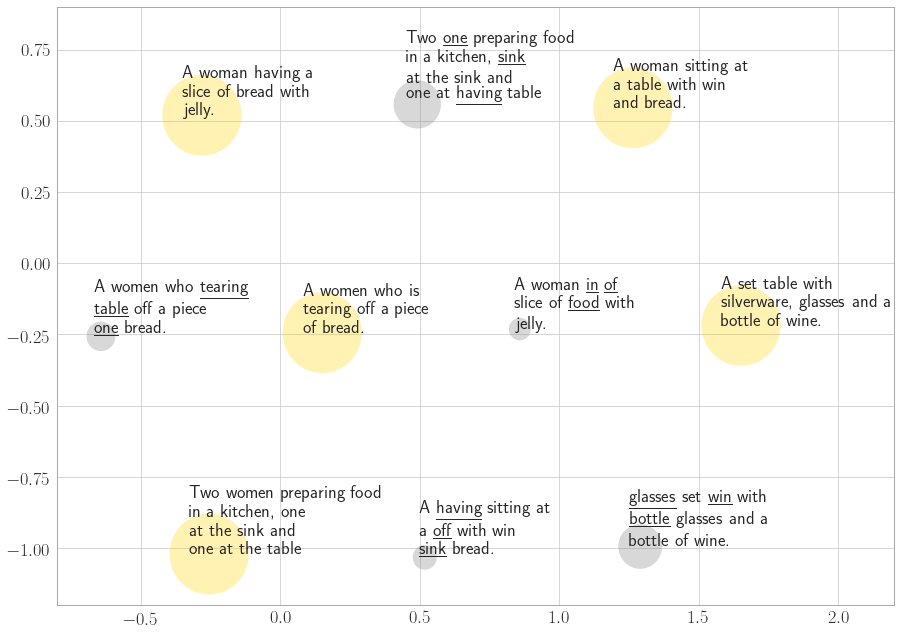

In [310]:
sns.set()
sns.set_style('whitegrid', rc={"axes.edgecolor": 'darkgray'})
sns.set_context('paper', font_scale=2.3, rc={"lines.linewidth": 2,
                                             "lines.markersize": 8})

f, ax = plt.subplots(1, 1, figsize=(15, 11))
e = 0
for coord, sent, score in zip(Infer2, gt+sampled, scores):
    coord = coord/100
    if e < 5:
        c = 'gold'
    else:
        c = 'grey'
        sent = highlight(sent, altered[e-5]) 
    final_s = r'%s' % fold(sent, 4)
    ax.text(coord[0]-score/2, coord[1], final_s , fontsize=18)
    ax.plot(coord[0], coord[1])
    ax.add_artist(Circle(coord,
                         radius=score,
                          color=c, alpha=0.3))
    e += 1
ax.set_xlim([-.8, 2.2])
ax.set_ylim([-1.2, .9])
plt.savefig('../figures/sent_bleu.png', dpi=400, bbox_inches='tight')